In [55]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [60]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Football/FIFA U-17/Data'
filedata = '/shots_fifa_u_17.xlsx'
df = pd.read_excel(PATH+filedata,sheet_name='Sheet1')

# Pipeline

In [9]:
class xgModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(23, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 96)
        self.linear4 = nn.Linear(96, 32)
        self.linear5 = nn.Linear(32, 1)
        self.relu = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.25)
    def forward(self, x):
        return self.linear5(self.relu(self.linear4(self.dropout(self.relu(self.linear3(self.dropout(self.relu(self.linear2(self.dropout(self.relu(self.linear1(x))))))))))))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = xgModel().to(device)

In [70]:
def preprocessing(dataframe):
  data = dataframe[['position', 'player_x', 'player_y', 'situation', 'bodyPart', 'goalMouth_y', 'goalMouth_z','shotType']]
  data = data[data['situation']!='shootout']
  data['goal'] = data['shotType'].apply(lambda x: 1 if x=='goal' else 0)
  data.drop(columns=['shotType'],inplace=True)

  # using statsbomb pitch coordinate
  data['player_x'] = data['player_x']*1.2
  data['player_y'] = data['player_y']*0.8
  data['goalMouth_y'] = data['goalMouth_y']*0.8

  #calculate distance to each post
  data['distanceToPostLeft'] = np.sqrt((data['player_x']**2 + (data['player_y']-36)**2))
  data['distanceToPostRight'] = np.sqrt((data['player_x']**2 + (data['player_y']-44)**2))

  # calculate the angle
  data['angle'] = np.arccos((data['distanceToPostLeft']**2+data['distanceToPostRight']**2-64)/(2*data['distanceToPostLeft']*data['distanceToPostRight']))*180/np.pi

  return data

def encode_data(dataframe):
  num_col_names = ['player_x','player_y','goalMouth_y','goalMouth_z','distanceToPostLeft','distanceToPostRight','angle']
  cat_col_names = ['position','situation','bodyPart']
  data = pd.get_dummies(dataframe,columns=cat_col_names)

  return data

def tensor_data(data):
  return torch.tensor(data.values.astype(np.float32))


In [13]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [64]:
def train_model(x_train, x_valid, y_train, y_valid, epochs, learning_rate):
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)

  # Send data to the device
  x_train, x_valid = x_train.to(device), x_valid.to(device)
  y_train, y_valid = y_train.to(device), y_valid.to(device)


  # Empty loss lists to track values
  epoch_count, train_loss_values, valid_loss_values = [], [], []

  # Loop through the data
  for epoch in range(epochs):

      # Put the model in training mode
      model.train()

      y_logits = model(x_train).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
      y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities

      loss = loss_fn(y_logits, y_train) # compute the loss
      acc = accuracy_fn(y_train.int(), y_pred) # calculate the accuracy; convert the labels to integers

      optimizer.zero_grad() # reset the gradients so they don't accumulate each iteration
      loss.backward() # backward pass: backpropagate the prediction loss
      optimizer.step() # gradient descent: adjust the parameters by the gradients collected in the backward pass

      # Put the model in evaluation mode
      model.eval()

      with torch.inference_mode():
          valid_logits = model(x_valid).squeeze()
          valid_pred = torch.round(torch.sigmoid(valid_logits))

          valid_loss = loss_fn(valid_logits, y_valid)
          valid_acc = accuracy_fn(y_valid.int(), valid_pred)

      # Print progress a total of 20 times
      if epoch % int(epochs / 20) == 0:
          print(f'Epoch: {epoch:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')

          epoch_count.append(epoch)
          train_loss_values.append(loss.detach().numpy())
          valid_loss_values.append(valid_loss.detach().numpy())

In [72]:
data = df.pipe(preprocessing).pipe(encode_data)

X = data.drop(columns=['goal'])
y = data['goal']
x_data, y_data = tensor_data(X), tensor_data(y)

x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,.25,shuffle=True)

train_model(x_train, x_test, y_train, y_test,1000, 0.0001)


Epoch:    0 | Train Loss: 0.54844, Accuracy: 88.68% | Validation Loss: 0.52445, Accuracy: 89.97%
Epoch:   50 | Train Loss: 0.35239, Accuracy: 88.68% | Validation Loss: 0.32505, Accuracy: 89.97%
Epoch:  100 | Train Loss: 0.34732, Accuracy: 88.68% | Validation Loss: 0.32066, Accuracy: 89.97%
Epoch:  150 | Train Loss: 0.33779, Accuracy: 88.68% | Validation Loss: 0.30860, Accuracy: 89.97%
Epoch:  200 | Train Loss: 0.31531, Accuracy: 88.68% | Validation Loss: 0.28834, Accuracy: 89.97%
Epoch:  250 | Train Loss: 0.29884, Accuracy: 88.68% | Validation Loss: 0.26860, Accuracy: 89.97%
Epoch:  300 | Train Loss: 0.28885, Accuracy: 88.68% | Validation Loss: 0.25458, Accuracy: 89.97%
Epoch:  350 | Train Loss: 0.27382, Accuracy: 89.22% | Validation Loss: 0.24842, Accuracy: 89.97%
Epoch:  400 | Train Loss: 0.25845, Accuracy: 90.58% | Validation Loss: 0.24145, Accuracy: 91.60%
Epoch:  450 | Train Loss: 0.25244, Accuracy: 90.22% | Validation Loss: 0.24090, Accuracy: 91.06%
Epoch:  500 | Train Loss: 0.25

In [73]:
# save the model
filename = 'xg_model'
torch.save(model, f'{PATH}/{filename}')

In [78]:
def check_columns(dataframe):
  default_cols = ['player_x', 'player_y', 'goalMouth_y', 'goalMouth_z',\
                  'distanceToPostLeft', 'distanceToPostRight', 'angle', 'position_D',\
                  'position_F', 'position_G', 'position_M', 'situation_assisted',\
                  'situation_corner', 'situation_fast-break', 'situation_free-kick',\
                  'situation_penalty', 'situation_regular', 'situation_set-piece',\
                  'situation_throw-in-set-piece', 'bodyPart_head', 'bodyPart_left-foot',\
                  'bodyPart_other', 'bodyPart_right-foot']

  for col in default_cols:
    if col not in dataframe.columns:
      dataframe[col] = False
  return dataframe


# Test

In [90]:
test = torch.load(f'{PATH}/{filename}')

test_data = df.iloc[:200].pipe(preprocessing).pipe(encode_data)

test_data = test_data.drop(columns=['goal'])
test_data = check_columns(test_data)

data_test = tensor_data(test_data)

test.eval()
res = test(data_test).squeeze()
test_data['xg'] = torch.sigmoid(res).detach().numpy()
test_data['xg'] = round(test_data['xg'],3)
test_data['goal'] = df['shotType'].iloc[:200].apply(lambda x: 1 if x=='goal' else 0)



<ipython-input-90-77cf9a721698>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load(f'{PATH}/{filename}')


In [92]:
cols_to_drop = [['position_D',	'position_F',	'position_M', 'position_G'],\
                ['situation_assisted',	'situation_corner',	'situation_fast-break',	'situation_free-kick',	'situation_penalty',	'situation_regular',	'situation_set-piece'	,'situation_throw-in-set-piece'],\
                ['bodyPart_head',	'bodyPart_left-foot',	'bodyPart_other',	'bodyPart_right-foot']]

test_data['position'] = test_data[cols_to_drop[0]].idxmax(axis=1)
test_data['position'] = test_data['position'].apply(lambda x: x[-1])
test_data['situation'] = test_data[cols_to_drop[1]].idxmax(axis=1)
test_data['situation'] = test_data['situation'].apply(lambda x: x.split('_')[1])
test_data['bodyPart'] = test_data[cols_to_drop[2]].idxmax(axis=1)
test_data['bodyPart'] = test_data['bodyPart'].apply(lambda x: x.split('_')[1])

test_data.drop(columns=cols_to_drop[0]+cols_to_drop[1]+cols_to_drop[2],inplace=True)

In [113]:
test_data.head(n=5)

,player_x,player_y,goalMouth_y,goalMouth_z,distanceToPostLeft,distanceToPostRight,angle,xg,goal,position,situation,bodyPart
0,14.832,43.392,30.144,7.6,16.571961,14.844456,28.838214,0.017,0,F,assisted,head
1,41.328,44.416,31.296,75.0,42.176209,41.330094,10.933572,0.001,0,M,free-kick,right-foot
2,28.368,21.120,34.176,5.7,32.033698,36.444997,11.209086,0.042,1,F,assisted,right-foot
3,16.560,40.384,33.344,80.6,17.130472,16.950193,27.145625,0.001,0,M,assisted,right-foot
4,13.680,36.672,29.696,13.3,13.696495,15.519085,30.988999,0.529,0,F,assisted,right-foot


# Visualizations

In [95]:
!pip install mplsoccer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 6.8 MB/s eta 0:00:00


In [96]:
from mplsoccer import VerticalPitch, Pitch

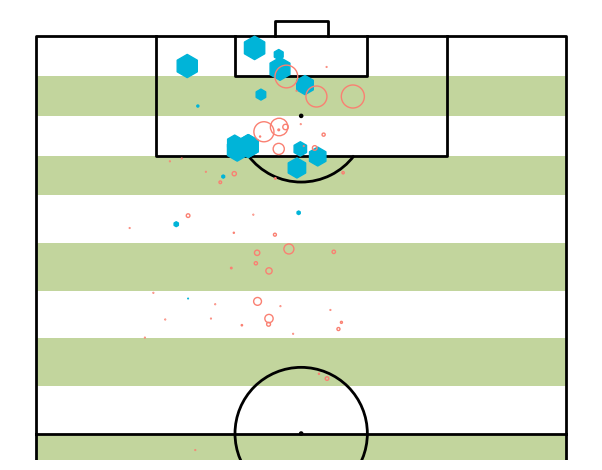

In [123]:
pitch = VerticalPitch(half=True, goal_type='box',line_color='black',stripe=True)
fig, ax = pitch.draw()
goals = test_data.loc[test_data['goal']==1][:50]
non_goals = test_data.loc[test_data['goal']==0][:50]

pitch.scatter(120-goals['player_x'],goals['player_y'],ax=ax, c='#00b4d8', s = goals['xg']*300, marker='h')
pitch.scatter(120-non_goals['player_x'],non_goals['player_y'],ax=ax, c='none', edgecolor='salmon', s = non_goals['xg']*300)